In [61]:
import csv
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import statsmodels.api as sm

from IPython import display
import math

%matplotlib inline

PALETTE = sns.color_palette("Paired")
LOW_BG = 3.888888888888889
HIGH_BG = 7.777777777777778

sns.set(style="whitegrid")
sns.set_palette("Paired")
data = pd.read_csv("output.csv", header=0, index_col=0, 
                   usecols=["Sequence","Timestamp","Value"],
                  )
data = data[["Timestamp", "Value"]]
data.set_index("Timestamp", inplace=True)
data.index = pd.to_datetime(data.index)
data["travel"] = 0

# First, only look at specified range
START_DATE = "2017-01-01"
END_DATE = "2017-06-30"

print("Date Range: " + START_DATE + " - " + END_DATE)
data = data[START_DATE:END_DATE]

travel_data = pd.read_csv("flights.csv", header=0)
#df['DateTime'] = df[['Year', 'Month', 'Day', 'Hour']].apply(lambda s : datetime.datetime(*s),axis = 1)
travel_data["Departure Date"] = pd.to_datetime(travel_data[['Departure Date', 'Departure Time']].apply(lambda s : datetime.datetime.strptime(s["Departure Date"] + " " + s["Departure Time"], "%Y-%m-%d %H:%M"), axis=1))
del travel_data["Departure Time"]

travel_data["Arrival Date"] = pd.to_datetime(travel_data[['Arrival Date', 'Arrival Time']].apply(lambda s : datetime.datetime.strptime(s["Arrival Date"] + " " + s["Arrival Time"], "%Y-%m-%d %H:%M"), axis=1))
del travel_data["Arrival Time"]
del travel_data["Num Days"]
del travel_data["Confirmation Number"]
del travel_data["Airline"]
del travel_data["Flight Number"]

# Set rows that match with travel data as travel or not travel
for row in travel_data[["Departure Date", "Arrival Date"]].values:
    cur_start = row[0]
    cur_end = row[1]
    data[cur_start:cur_end]["travel"] = 1

def set_time(data, time_col, start, end):
    data[time_col] = data.index.isin(data.between_time(start, end, include_start=True, include_end=True).index)
    data[time_col] = data[time_col].apply(lambda r: 1 if r==True else 0)

set_time(data, "extra_early", "02:01", "06:29")
set_time(data, "before_breakfast", "06:30", "09:00")
set_time(data, "breakfast", "09:01", "10:30")
set_time(data, "after_breakfast", "10:31", "11:30")

set_time(data, "before_lunch", "11:31", "12:15")
set_time(data, "lunch", "12:16", "13:46")
set_time(data, "after_lunch", "13:47", "16:00")

set_time(data, "before_dinner", "16:01", "18:00")
set_time(data, "dinner", "18:01", "19:30")
set_time(data, "after_dinner", "19:31", "22:00")

set_time(data, "evening", "22:01", "23:59")
set_time(data, "extra_evening", "00:00", "02:00")

data.reset_index(inplace=True)
# data = data.replace(True,"1").replace(False,"0")


Date Range: 2017-01-01 - 2017-06-30


/Users/suppe/virtualenvs/contourtool/lib/python3.6/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Linear Regression

In [55]:
# Shuffle array and reset index so there's no ranking
diabetes_X = data.sample(frac=1).reset_index(drop=True)
del diabetes_X["Timestamp"]

270 total samples, splitting 90% split (243/27)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.6353
Date:                Wed, 05 Jul 2017   Prob (F-statistic):              0.811
Time:                        00:25:15   Log-Likelihood:                -620.55
No. Observations:                 243   AIC:                             1267.
Df Residuals:                     230   BIC:                             1313.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.5187      0.240     27.161      0.000       6.046       6.992
extra_early          0.2784      0.804      0.346      0.729      -1.305       1.862
before_breakfast     0.3159      0.625      0.506      0.614      -0.915       1.547
breakfast            1.3625      0.773      1.762      0.079      -0.161       2.886
after_breakfast     -0.0338      0.851     -0.040      0.968      -1.711       1.644
before_lunch         0.9378      1.066      0.880      0.380      -1.163       3.039
lunch                0.4589      0.697      0.659      0.511      -0.914       1.832
after_lunch          0.2665      0.537      0.496      0.620      -0.792       1.325
before_dinner        0.7727      0.594      1.302      0.194      -0.397       1.942
dinner               2.1613      0.796      2.714      0.007       0.592       3.730
after_dinner         0.4001      0.521      0.769      0.443      -0.626       1.426
evening              0.2789      0.697      0.400      0.689      -1.094       1.652
extra_evening       -0.6807      1.499     -0.454      0.650      -3.634       2.272
travel              -0.5522      0.985     -0.560      0.576      -2.493       1.389
==============================================================================
Omnibus:                       26.568   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.940
Skew:                           0.868   Prob(JB):                     1.16e-07
Kurtosis:                       3.373   Cond. No.                     6.36e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.67e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Intercept           1.035620e-73
extra_early         7.293137e-01
before_breakfast    6.135609e-01
breakfast           7.944760e-02
after_breakfast     9.684127e-01
before_lunch        3.800127e-01
lunch               5.108749e-01
after_lunch         6.201957e-01
before_dinner       1.942439e-01
dinner              7.153335e-03
after_dinner        4.429565e-01
evening             6.893724e-01
extra_evening       6.501633e-01
travel              5.756925e-01
dtype: float64

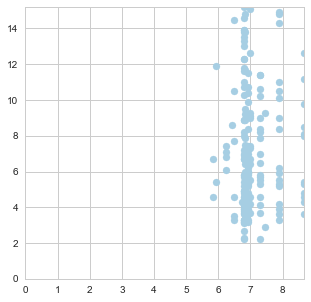

In [60]:
TRAINING_PCT = .9
cut = math.ceil(len(data)*TRAINING_PCT)
print("%d total samples, splitting %d%% split (%d/%d)" %(len(data), TRAINING_PCT*100, cut,(len(data)-cut)))

# Split the data into training/testing sets
diabetes_train = diabetes_X[:cut]
diabetes_test = diabetes_X[cut:]

model = sm.OLS.from_formula(formula="Value ~ extra_early+before_breakfast+breakfast+after_breakfast+" +\
                                    "before_lunch+lunch+after_lunch+before_dinner+dinner+after_dinner+evening+" +\
                                    "extra_evening+travel", data=diabetes_train).fit()
predictions = model.predict(diabetes_X_test) # make the predictions by the model

fig, ax = plt.subplots(1,1,figsize=(5,5))
foo = ax.scatter(predictions, diabetes_y_test)
foo = ax.set_xlim(0,predictions.max())
foo = ax.set_ylim(0,diabetes_y_test.max())

display.display(model.summary())
display.display(model.pvalues)